# LSTM, word embedding, enrich domain 2

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [3]:
# Import data
import zipfile

zip_file = zipfile.ZipFile('llm-detect-ai-generated-text.zip')
train_data = zip_file.open('train_essays.csv')
train_prompts = zip_file.open('train_prompts.csv')
# test data is just exmaple data, not the actual test data
test_data = zip_file.open('test_essays.csv')
sample_sub = zip_file.open('sample_submission.csv')

data_train = pd.read_csv(train_data)
data_test = pd.read_csv(test_data)
train_prompts =  pd.read_csv(train_prompts)
sample_sub =  pd.read_csv(sample_sub)

In [4]:
# external data
daigt_file = zipfile.ZipFile('daigt.zip')
argugpt_file = zipfile.ZipFile('argugpt.zip')
daigt_data = daigt_file.open('train_drcat_04.csv')
argugpt_data = argugpt_file.open('argugpt.csv')
daigt_data = pd.read_csv(daigt_data)[['essay_id', 'text', 'label']]
# rename columns to match the other data
daigt_data.columns = ['id', 'text', 'generated']
argugpt_data = pd.read_csv(argugpt_data)[['id', 'text']]
argugpt_data.columns = ['id', 'text']
# add column 'generated' full of 1 to match the other data
argugpt_data['generated'] = 1

In [5]:
daigt_data.head()

,id,text,generated
0,E897534557AF,"In recent years, technology has had a profoun...",1
1,DFBA34FFE11D,Should students participate in an extracurricu...,0
2,af37ecf5,The electoral college is a symbol of mockery a...,0
3,5EC2696BAD78,This is why I think the principle should allow...,0
4,llama_70b_v1843,I strongly believe that meditation and mindful...,1


In [6]:
argugpt_data.head()

,id,text,generated
0,weccl_30,There are many people who think that universit...,1
1,weccl_51,There are a number of reasons why people might...,1
2,weccl_48,There are many reasons why university educatio...,1
3,weccl_50,There are many people who think that universit...,1
4,weccl_55,There is a general consensus that university e...,1


In [7]:
print(data_train.shape)
data_train.head()

(1378, 4)


,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0


In [8]:
# concate all data by matching columns
data_train = pd.concat([data_train, daigt_data, argugpt_data], axis=0, ignore_index=True)
print(data_train.shape)
data_train.head()

(49622, 4)


,id,prompt_id,text,generated
0,0059830c,0.0,Cars. Cars have been around since they became ...,0
1,005db917,0.0,Transportation is a large necessity in most co...,0
2,008f63e3,0.0,"""America's love affair with it's vehicles seem...",0
3,00940276,0.0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0.0,Cars are a wonderful thing. They are perhaps o...,0


In [9]:
# drop prompt_id column
data_train.drop('prompt_id', axis=1, inplace=True)

# EDA

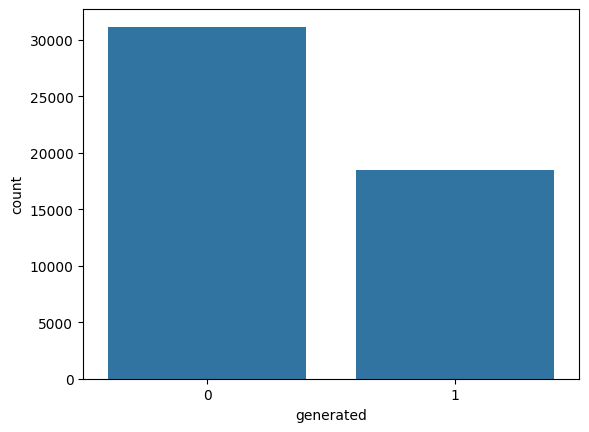

In [10]:
# check and plot the distribution of the prompt_id and generated attributes
import matplotlib.pyplot as plt
import seaborn as sns
sns.countplot(x="generated", data=data_train)
plt.show()

count    49622.000000
mean      2202.182862
std        999.441348
min        239.000000
25%       1515.000000
50%       2035.000000
75%       2631.000000
max      18322.000000
Name: text, dtype: float64


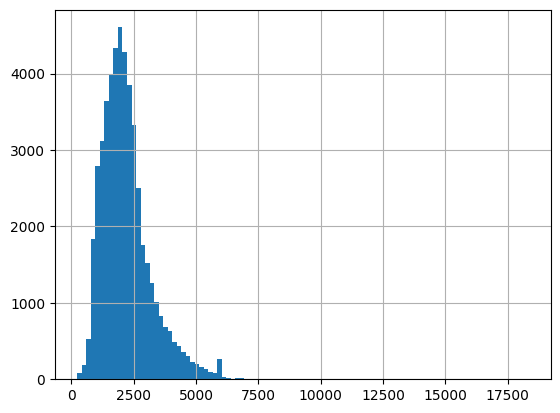

In [11]:
# plot the distribution of the length of the essays in the text attribute
data_train['text'].str.len().hist(bins = 100)
print(data_train['text'].str.len().describe())
plt.show()

In [12]:
data_train['text'].str.len().describe().mean()

9695.703026327905

In [13]:
# count text with len > mean + 3 std deviation
mean = data_train['text'].str.len().describe()['mean']
std = data_train['text'].str.len().describe()['std']
print(data_train[data_train['text'].str.len() > mean + 3*std].shape)

(768, 3)


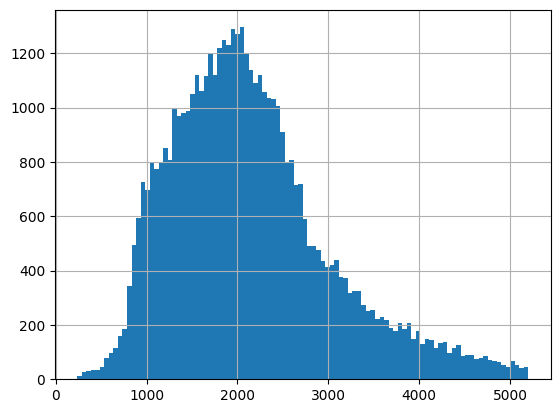

In [14]:
# delete text with len > mean + 3 std deviation
data_train = data_train[data_train['text'].str.len() < mean + 3*std]
data_train['text'].str.len().hist(bins = 100)
plt.show()

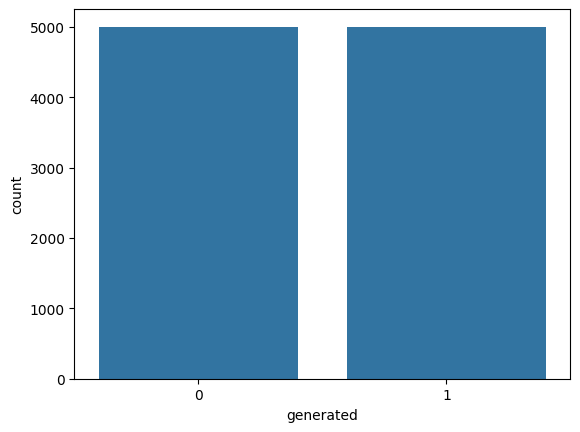

In [16]:
# only keep 5000 of each label
data_train = data_train.groupby('generated').head(5000)
sns.countplot(x="generated", data=data_train)
plt.show()


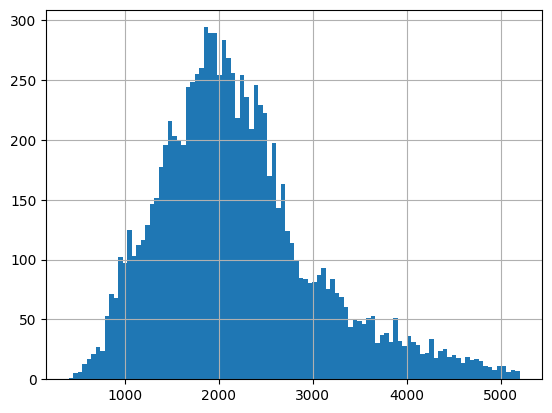

In [18]:
data_train['text'].str.len().hist(bins = 100)
plt.show()

In [17]:
import nltk
nltk.download('words')
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import words
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
# import tokenize words
word_list = words.words()

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\33610\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\33610\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\33610\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [19]:
from tqdm import tqdm

def preprocess_text(text_series):
    # Convert to lower case
    text_series = text_series.str.lower()
    # Tokenize the words
    text_series = text_series.str.split()
    # Only keep words that are in the word_list
    text_series = text_series.progress_apply(lambda words: ' '.join(word for word in words if word in word_list))
    # Only keep words that are alphanum (not punctuation)
    text_series = text_series.str.split().progress_apply(lambda words: ' '.join(word for word in words if word.isalnum()))
    # Remove stopwords
    stopwords_set = set(stopwords.words('english'))
    text_series = text_series.str.split().progress_apply(lambda words: ' '.join(word for word in words if word not in stopwords_set))
    return text_series

# Apply the function
tqdm.pandas()
data_train['text'] = preprocess_text(data_train['text'])

100%|██████████| 10000/10000 [00:00<00:00, 44530.06it/s]


Additional papers referenced in esssays:
- "Carfree day is spinning into a big hit in Bogota," by Andrew Selsky
- "Paris bans driving due to smog" by Robert Duffer
- Bradford Plumer

In [47]:
data_train['text'].head()

0    around since famous henry ford built first maj...
1    transportation large necessity transportation ...
2    love affair understand easier suggest car usag...
3    often ride drive one motor vehicle ever though...
4    wonderful perhaps one get us point point exact...
Name: text, dtype: object

In [38]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# layers size
layer_size = 128

X = data_train['text'].to_numpy()
# Get the target values
Y = data_train['generated'].to_numpy()

# Split the data into training and testing
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, random_state = 42)

# # Prepare text for LSTM 
# tokenizer = Tokenizer(num_words=5000, split=' ')
# tokenizer.fit_on_texts(X_train.values)
# X_train = tokenizer.texts_to_sequences(X_train.values)
# X_train = pad_sequences(X_train, maxlen=layer_size)
# X_test = tokenizer.texts_to_sequences(X_test.values)
# X_test = pad_sequences(X_test, maxlen=layer_size)

# print('before resampling (training sample):')
# print(f'shape of data tensor: {X_train.shape}')
# print(f'shape of label: {Y_train.shape}')
# print('class distribution (train):', Y_train.value_counts())
# print('class distribution (test):', Y_test.value_counts())

# # # resample training data to oversample humans
# sm = SMOTE(random_state=12)
# X_train, Y_train = sm.fit_resample(X_train, Y_train)

# print('after resampling (training data):')
# print(f'shape of data tensor: {X_train.shape}')
# print(f'shape of label: {X_train.shape}')
# print('class distribution:', Y_train.value_counts())

# not a very good idea
Y_train = pd.get_dummies(Y_train).values
Y_test = pd.get_dummies(Y_test).values

In [39]:
import tensorflow_hub as hub
import tensorflow as tf

model = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(model, input_shape=[], dtype=tf.string, trainable=True)
hub_layer(X_train[:1])

<tf.Tensor: shape=(1, 50), dtype=float32, numpy=
array([[ 5.12287378e-01, -1.12889516e+00,  3.17568362e-01,
        -2.92477936e-01, -1.27041721e+00, -1.10778175e-01,
        -3.13505054e-01,  5.71780741e-01, -9.37380791e-01,
         2.38300443e-01,  3.96323293e-01, -2.30548054e-01,
         3.32381308e-01, -4.37096328e-01,  3.03699262e-02,
         2.94808447e-02,  2.43208528e-01, -7.95825779e-01,
         7.16659009e-01, -1.30693400e+00,  2.51713861e-03,
        -1.27348598e-04,  4.87651557e-01, -1.70067981e-01,
        -3.67686242e-01,  2.91696519e-01,  2.18778491e-01,
        -2.53676157e-03,  6.04423881e-01, -7.83193171e-01,
        -1.71234861e-01,  1.05157420e-01,  5.62157929e-01,
        -4.81711924e-01, -5.98021150e-01, -1.00311315e+00,
        -1.89920247e-01, -3.98384631e-02, -6.19649477e-02,
        -3.22284818e-01, -5.54992519e-02, -2.86089815e-02,
         6.16812766e-01,  2.13542879e-01,  1.42603680e-01,
        -7.73992062e-01, -2.10566014e-01, -3.13815512e-02,
       

In [40]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, Reshape

# init layer
model = Sequential()
model.add(hub_layer)
model.add(Reshape((1, -1))) # Add this line to reshape the 2D tensor to a 3D tensor
model.add(Bidirectional(LSTM(25,return_sequences=True)))
model.add(Bidirectional(LSTM(16,return_sequences=False)))
model.add(Dropout(0.2))
model.add(Dense(32,activation="relu"))
model.add(Dense(2, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [41]:
for layer in model.layers:
    print(layer.output_shape)

(None, 50)
(None, 1, 50)
(None, 1, 50)
(None, 32)
(None, 32)
(None, 32)
(None, 2)


In [42]:
batch_size = 64 
epochs = 10
history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_split=0.2)

Epoch 1/10
100/100 [==============================] - 62s 576ms/step - loss: 0.3294 - accuracy: 0.8775 - val_loss: 0.0978 - val_accuracy: 0.9706
Epoch 2/10
100/100 [==============================] - 58s 581ms/step - loss: 0.0528 - accuracy: 0.9814 - val_loss: 0.0735 - val_accuracy: 0.9800
Epoch 3/10
100/100 [==============================] - 60s 596ms/step - loss: 0.0211 - accuracy: 0.9937 - val_loss: 0.0798 - val_accuracy: 0.9794
Epoch 4/10
100/100 [==============================] - 59s 595ms/step - loss: 0.0118 - accuracy: 0.9969 - val_loss: 0.1175 - val_accuracy: 0.9737
Epoch 5/10
100/100 [==============================] - 64s 637ms/step - loss: 0.0037 - accuracy: 0.9987 - val_loss: 0.1107 - val_accuracy: 0.9769
Epoch 6/10
100/100 [==============================] - 59s 585ms/step - loss: 0.0014 - accuracy: 0.9995 - val_loss: 0.1222 - val_accuracy: 0.9769
Epoch 7/10
100/100 [==============================] - 58s 584ms/step - loss: 4.1466e-04 - accuracy: 1.0000 - val_loss: 0.1298 - va

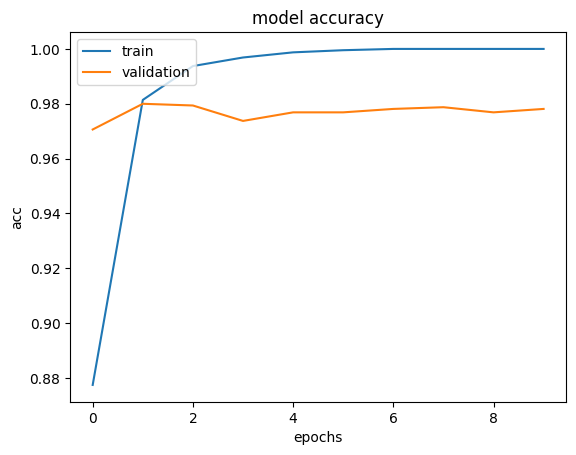

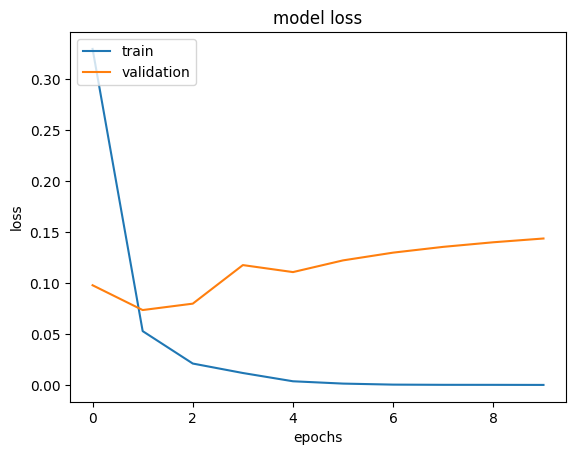

In [43]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epochs')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [50]:
# predict probabilities for test set
yhat_probs = model.predict(X_test, verbose=0)
# predict classes for test set
yhat_classes = [np.argmax(classes) for classes in yhat_probs]

In [45]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Check against true class
Y_true = [np.argmax(classes) for classes in Y_test]

cm = confusion_matrix(yhat_classes, Y_true)
cm

print(f"Confusion metrics: {cm}")
print(classification_report(yhat_classes, Y_true))

Confusion metrics: [[996  20]
 [ 18 966]]
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1016
           1       0.98      0.98      0.98       984

    accuracy                           0.98      2000
   macro avg       0.98      0.98      0.98      2000
weighted avg       0.98      0.98      0.98      2000



In [46]:
# count values of yhat_classes and Y_true
from collections import Counter

print(Counter(yhat_classes))
print(Counter(Y_true))

Counter({0: 1016, 1: 984})
Counter({0: 1014, 1: 986})


In [ ]:
# # Predict test data
# test_data = pd.read_csv('Data/test_data.csv')
# X_test = test_data['text'].to_numpy()
# y_pred = model.predict(X_test, verbose=0)
# y_pred = [np.argmax(classes) for classes in y_pred]
# y_pred_binary = [1 if e == 8 else 0 for e in y_pred]

# # Save the prediction
# result = pd.DataFrame(y_pred_binary, columns=['class'])
# result['id'] = result.index
# result.to_csv(f'Output/{model_name}.csv', columns=['id', 'class'],index=False)

In [ ]:
# # save model
# import joblib

# output_folder = './Models'
# joblib.dump(model, f"{output_folder}/{model_name}.pkl")